  #                         Analytics Vidhya - INDIA ML Hiring Hackathon 2019

## Loan Delinquency Prediction


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from sklearn.model_selection import GridSearchCV,KFold, cross_val_score
import time
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, auc


In [2]:
train = pd.read_csv("train.csv")
train.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,...,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,...,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,...,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,...,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,...,3,4,5,6,7,8,9,10,11,1


In [3]:
train.drop('loan_id',axis=1, inplace=True)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116058 entries, 0 to 116057
Data columns (total 28 columns):
source                      116058 non-null object
financial_institution       116058 non-null object
interest_rate               116058 non-null float64
unpaid_principal_bal        116058 non-null int64
loan_term                   116058 non-null int64
origination_date            116058 non-null object
first_payment_date          116058 non-null object
loan_to_value               116058 non-null int64
number_of_borrowers         116058 non-null float64
debt_to_income_ratio        116058 non-null float64
borrower_credit_score       116058 non-null float64
loan_purpose                116058 non-null object
insurance_percent           116058 non-null float64
co-borrower_credit_score    116058 non-null float64
insurance_type              116058 non-null float64
m1                          116058 non-null int64
m2                          116058 non-null int64
m3                  

### Lets see how the target variable 'm13' is distributed in the train file.

   From the below plot we can see that the data is highly imbalanced and it will be hard for the model to predict the target '1' which is what we are looking for. In real scenario we should collect more data to balance the target variable distribution so the model has enough data to train on both the classifcation and won't be biased.

Text(0, 0.5, 'Count')

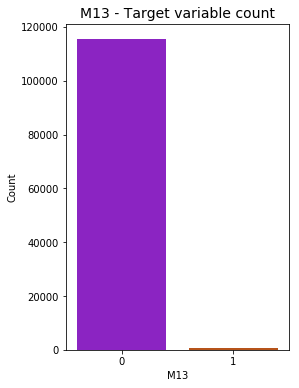

In [5]:
plt.figure(figsize=(4,6))
sns.countplot(x='m13',data=train,palette='gnuplot')
plt.title('M13 - Target variable count', fontsize=14)
plt.xlabel('M13', fontsize=10)
plt.ylabel('Count',fontsize=10)

### Checking for Outliers

By quickly plotting a scatterplot of the variable we can easily see how it is distributed and spot any outliers. Other ways to spot outliers would be to calculate Z-score or Standard Deviation among other methods and find if a particular data point is deviating too much from the distribution.

From the below plot we can see for the 'unpaid_principal_bal' the data is distributed evenly until around 620000 but then start to deviate too much from data range

Text(0.5, 1.0, 'Unpaid principal balance')

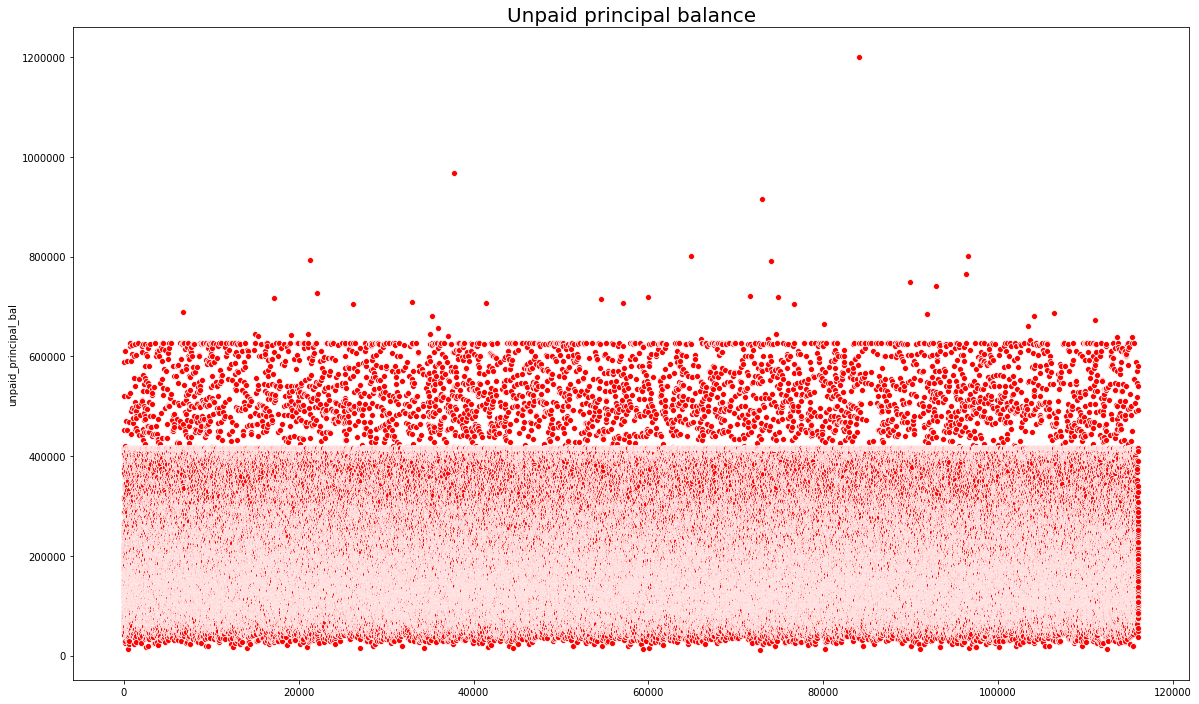

In [6]:
plt.figure(figsize=(20,12))
sns.scatterplot(x=train.index, y='unpaid_principal_bal',data=train,color='red')
plt.title("Unpaid principal balance", fontsize=20)

Below is the closer look. Let's consider anything above 790000 as outliers.

Text(0.5, 1.0, 'Unpaid principal balance greater than $620000')

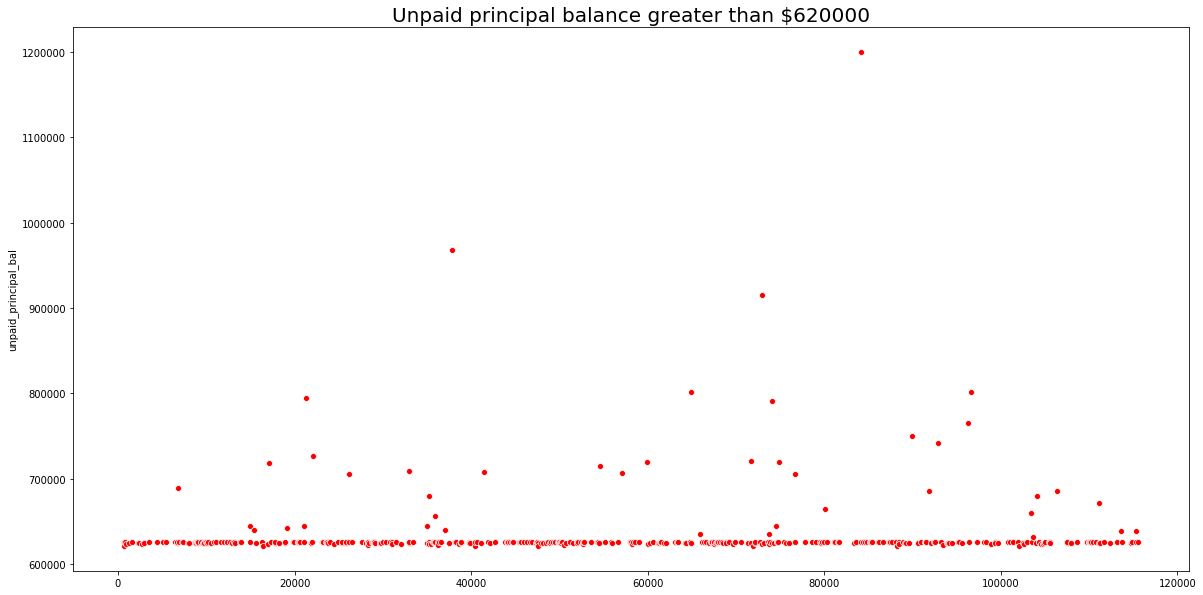

In [7]:
data=train[train['unpaid_principal_bal']>620000]
plt.figure(figsize=(20,10))
sns.scatterplot(x=data.index, y='unpaid_principal_bal',data=data,color='red')
plt.title("Unpaid principal balance greater than $620000", fontsize=20)

Similary by checking the other end of the range we don't see any extreme deviation from other data points so this okay.

Text(0.5, 1.0, 'Upaid principal balance lesser than $50000')

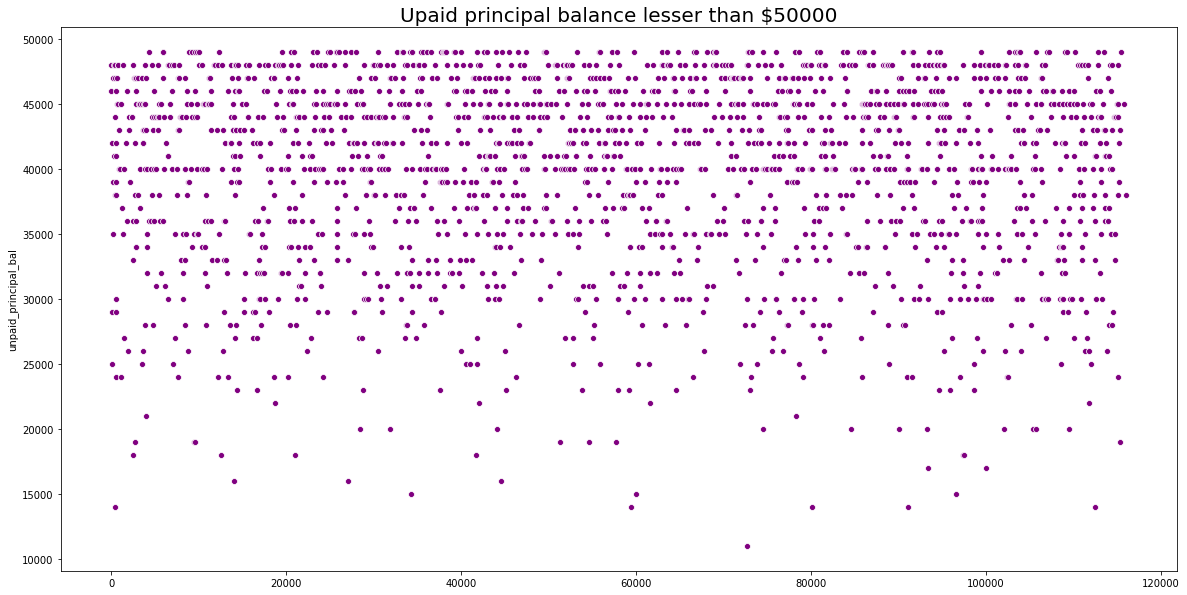

In [8]:
data=train[train['unpaid_principal_bal']<50000]
plt.figure(figsize=(20,10))
sns.scatterplot(x=data.index, y='unpaid_principal_bal',data=data,color='purple')
plt.title("Upaid principal balance lesser than $50000", fontsize=20)

Let us remove the outliers that are above 790000 and consider the rest of the data for training.

As for other columns some of them are already in binary form while some are in ratios and doesn't seem to be any outlier.

In [9]:
train = train[train['unpaid_principal_bal']<790000]

#### Take a look at the date feature

This data can be considered redundant as we can see below given is the only dates that are available in the entire file and I don't see much use of this data and hence can be removed

In [10]:
train['origination_date'].value_counts()

2012-02-01    52332
2012-01-01    49088
2012-03-01    14631
Name: origination_date, dtype: int64

In [11]:
train['first_payment_date'].value_counts()

04/2012    52838
03/2012    47675
05/2012    15014
02/2012      524
Name: first_payment_date, dtype: int64

In [12]:
train.drop(['origination_date','first_payment_date'], axis=1, inplace=True)

In [13]:
train.isnull().values.any()

False

#### Converting Categorical values to Binary values

In [14]:
dummies = pd.get_dummies(train[['source','financial_institution','loan_purpose']])
dummies.head(3)

,source_X,source_Y,source_Z,financial_institution_Anderson-Taylor,financial_institution_Browning-Hart,financial_institution_Chapman-Mcmahon,"financial_institution_Cole, Brooks and Vincent",financial_institution_Edwards-Hoffman,"financial_institution_Martinez, Duffy and Bird","financial_institution_Miller, Mcclure and Allen",...,"financial_institution_Sanchez, Hays and Wilkerson",financial_institution_Sanchez-Robinson,financial_institution_Suarez Inc,"financial_institution_Swanson, Newton and Miller","financial_institution_Taylor, Hunt and Rodriguez",financial_institution_Thornton-Davis,"financial_institution_Turner, Baldwin and Rhodes",loan_purpose_A23,loan_purpose_B12,loan_purpose_C86
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [15]:
train.drop(['source','financial_institution','loan_purpose'], axis=1, inplace=True)
final_train = train.join(dummies)
final_train.head()

,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,...,"financial_institution_Sanchez, Hays and Wilkerson",financial_institution_Sanchez-Robinson,financial_institution_Suarez Inc,"financial_institution_Swanson, Newton and Miller","financial_institution_Taylor, Hunt and Rodriguez",financial_institution_Thornton-Davis,"financial_institution_Turner, Baldwin and Rhodes",loan_purpose_A23,loan_purpose_B12,loan_purpose_C86
0,4.250,214000,360,95,1.0,22.0,694.0,30.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
1,4.875,144000,360,72,1.0,44.0,697.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,3.250,366000,180,49,1.0,33.0,780.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0
3,4.750,135000,360,46,2.0,44.0,633.0,0.0,638.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,4.750,124000,360,80,1.0,43.0,681.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
final_train.isnull().values.any()

False

List of columns that we are finally going to use in our Model

In [17]:
final_train.columns

Index(['interest_rate', 'unpaid_principal_bal', 'loan_term', 'loan_to_value',
       'number_of_borrowers', 'debt_to_income_ratio', 'borrower_credit_score',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13', 'source_X', 'source_Y', 'source_Z',
       'financial_institution_Anderson-Taylor',
       'financial_institution_Browning-Hart',
       'financial_institution_Chapman-Mcmahon',
       'financial_institution_Cole, Brooks and Vincent',
       'financial_institution_Edwards-Hoffman',
       'financial_institution_Martinez, Duffy and Bird',
       'financial_institution_Miller, Mcclure and Allen',
       'financial_institution_Nicholson Group', 'financial_institution_OTHER',
       'financial_institution_Richards-Walters',
       'financial_institution_Richardson Ltd',
       'financial_institution_Romero, Woods and Johnson',
       'financial_institution_Sanchez, Hay

In [18]:
X = final_train.drop('m13',axis=1)
y = final_train['m13']

### Standardization


In [19]:
X_scaled = StandardScaler().fit_transform(X)
X_scaled[0]

C:\Users\vicky\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\vicky\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([ 0.82658448,  0.05076241,  0.75444983,  1.59425178, -1.20753251,
       -0.89845052, -1.79872431,  3.36108939, -1.20334711, -0.05716496,
       -0.05045953, -0.04007308, -0.03560016, -0.03507033, -0.04275094,
       -0.03907135,  9.86330946, -0.04265371, -0.04179275, -0.04458394,
       -0.04364305, -0.04527755, -1.10609891, -0.69164696,  2.63171011,
       -0.06464795, -0.6150164 , -0.05791868, -0.11979991, -0.2089986 ,
       -0.20578942, -0.16725248, -0.1362463 , -0.8654444 , -0.11283673,
       -0.06397245, -0.08065181, -0.0859994 , -0.10191535, -0.12516344,
       -0.25092226, -0.10468456, -0.07510824,  7.8655068 , -1.00742952,
       -0.58226231,  1.76447937])

### Train test split

Let us split our train file into train and test using train_test_split to see how it performs across different models and select the appropriate one to finally apply the model on the actual test data

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=101)

### Training the data using various model  
  
   1. We'll be doing GridSearch for each model to find the best parmaters to tune in the model.
   2. Use those parameters to fit the model and predict the test data.
   3. Use KFold Cross validation to validate how the tuned in model had performed.

### Logistic Regression

In [48]:
##  GridSearchCV --  LogisticRegression

from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()

param_grid = {
    'dual':[True,False],
    'max_iter':[100,110,120,130,140]
}

grid = GridSearchCV(estimator=log_model, param_grid=param_grid, scoring='f1', cv = 3, n_jobs=-1)

start_time = time.time()
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best F1 score is %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

C:\Users\vicky\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best F1 score is 0.505543 using {'dual': True, 'max_iter': 130}
Execution time: 37.265132904052734 ms


C:\Users\vicky\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [22]:
## LogisticRegression - Fitting the model and predicting the data

log_model = LogisticRegression(dual=True , max_iter=130)
log_model.fit(X_train,y_train)
log_pred = log_model.predict(X_test)
log_probs = log_model.predict_proba(X_test)[:,1]


print("F1 Score is",f1_score(y_test,log_pred))

C:\Users\vicky\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 Score is 0.4575645756457565


C:\Users\vicky\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [23]:
## KFold, cross_val_score

kfold = KFold(n_splits=3, random_state=7)
result = cross_val_score(log_model, X_train, y_train, cv=kfold, scoring='f1')

print("KFold F1 Score is",result.mean())

C:\Users\vicky\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vicky\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\vicky\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vicky\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\vicky\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this 

KFold F1 Score is 0.48957347176447236


C:\Users\vicky\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Random Forest Classifier

In [21]:
##  GridSearchCV --  RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier()

param_grid = {  
    'max_features': ['auto', None],
    'n_estimators': [100, 200, 300, 400, 600, 800, 1000]
}

grid = GridSearchCV(estimator=rfc_model, param_grid=param_grid, scoring='f1', cv = 3, n_jobs=-1)

start_time = time.time()
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best F1 score is %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best F1 score is 0.489337 using {'max_features': 'auto', 'n_estimators': 1000}
Execution time: 3015.260643005371 ms


In [24]:
## RandomForestClassifier - Fitting the model and predicting the data

rfc_model = RandomForestClassifier(n_estimators=1000 ,max_features='auto' )
rfc_model.fit(X_train,y_train)
rfc_pred = rfc_model.predict(X_test)
rfc_probs = rfc_model.predict_proba(X_test)[:,1]


print("F1 Score is",f1_score(y_test,rfc_pred))

F1 Score is 0.43410852713178294


In [25]:
## KFold, cross_val_score

kfold = KFold(n_splits=3, random_state=7)
result = cross_val_score(rfc_model, X_train, y_train, cv=kfold, scoring='f1')

print("KFold F1 Score is",result.mean())

KFold F1 Score is 0.48401895430024783


### K Nearest Neighbour

In [25]:
##  GridSearchCV --  KNN

from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()

param_grid = {  
    'n_neighbors': [5,7,9,11,13],
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan']
}

grid = GridSearchCV(estimator=knn_model, param_grid=param_grid, scoring='f1', cv = 3, n_jobs=-1)

start_time = time.time()
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best F1 score is %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best F1 score is 0.435672 using {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Execution time: 6025.300405740738 ms


In [26]:
## KNeighborsClassifier - Fitting the model and predicting the data

knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance' , metric='euclidean' )
knn_model.fit(X_train,y_train)
knn_pred = knn_model.predict(X_test)
knn_probs = knn_model.predict_proba(X_test)[:,1]


print("F1 Score is",f1_score(y_test,knn_pred))

F1 Score is 0.393939393939394


In [27]:
## KFold, cross_val_score

kfold = KFold(n_splits=3, random_state=7)
result = cross_val_score(knn_model, X_train, y_train, cv=kfold, scoring='f1')

print("KFold F1 Score is",result.mean())

KFold F1 Score is 0.43937895777986863


### Decision Tree

In [28]:
##  GridSearchCV --  Decision Tree

from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier()

param_grid = {  
    'max_features': ['auto', None],
    'max_depth': [3,5,7,9,11,13,15,None]
}

grid = GridSearchCV(estimator=dtree_model, param_grid=param_grid, scoring='f1', cv = 3, n_jobs=-1)

start_time = time.time()
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best F1 score is %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best F1 score is 0.480621 using {'max_depth': 7, 'max_features': None}
Execution time: 14.064442873001099 ms


In [28]:
##  DecisionTreeClassifier - Fitting the model and predicting the data

dtree_model = DecisionTreeClassifier(max_features=None, max_depth=7)
dtree_model.fit(X_train,y_train)
dtree_pred = dtree_model.predict(X_test)
dtree_probs = dtree_model.predict_proba(X_test)[:,1]


print("F1 Score is",f1_score(y_test,dtree_pred))

F1 Score is 0.43356643356643354


In [29]:
## KFold, cross_val_score

kfold = KFold(n_splits=3, random_state=7)
result = cross_val_score(dtree_model, X_train, y_train, cv=kfold, scoring='f1')

print("KFold F1 Score is",result.mean())

KFold F1 Score is 0.47183573182621297


### Precision-Recall curve

Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. Specifically, there are many examples of no event (class 0) and only a few examples of an event (class 1).

The reason for this is that typically the large number of class 0 examples means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives.

In [56]:
##  Function to plot Precision-Recall curve

sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
    
def plotPR(y_test, probs, pred, label):
    
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    
    # calculate precision-recall AUC
    au = auc(recall, precision)
    
    # calculate average precision score    
    f1 = f1_score(y_test,pred)
    
    # calculate average precision score   
    ap = average_precision_score(y_test, probs)
    
    print(label+': F1 Score = %.3f, AUC = %.3f, Avg Precision = %.3f' % (f1, au, ap))
    
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    
    # plot no skill,
    plt.plot([0, 1], [0.5, 0.5], linestyle='--', color='navy', lw=2)
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, color= c, lw=2, label = label +'(Avg Precision = %.3f)' %ap)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall',fontsize=12)
    plt.ylabel('Precision',fontsize=12)
    plt.title('Precision vs Recall Curve') #Receiver Operating Characteristic 
    plt.legend(bbox_to_anchor=(0.7, 0.87),loc = 10)


Logistic Reg : F1 Score = 0.458, AUC = 0.443, Avg Precision = 0.443
Random Forest : F1 Score = 0.434, AUC = 0.489, Avg Precision = 0.488
KNN : F1 Score = 0.394, AUC = 0.392, Avg Precision = 0.344
Decision Tree : F1 Score = 0.434, AUC = 0.387, Avg Precision = 0.311


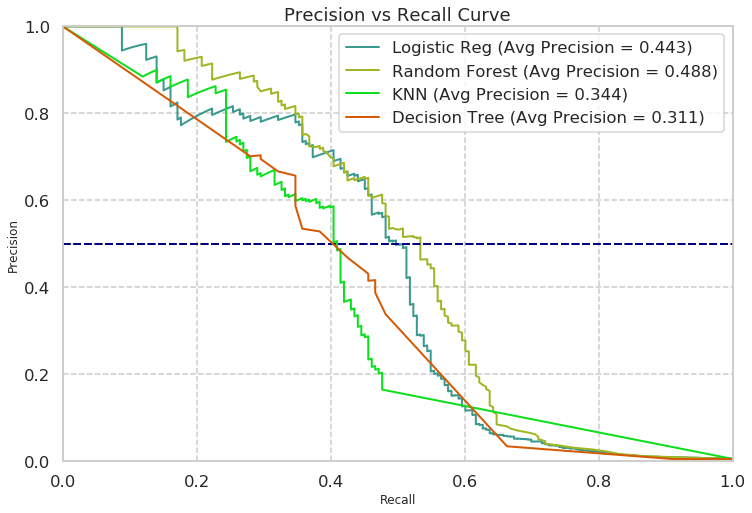

In [69]:
plt.figure(figsize=(12,8))
plotPR(y_test, log_probs, log_pred, 'Logistic Reg ')
plotPR(y_test, rfc_probs, rfc_pred, 'Random Forest ')
plotPR(y_test, knn_probs, knn_pred, 'KNN ')
plotPR(y_test, dtree_probs, dtree_pred, 'Decision Tree ')
plt.show()

### Test Data
#### Let's apply all the changes that we have done on the train file to the test file

In [82]:
test = pd.read_csv("test.csv")
test.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,Y,Browning-Hart,3.875,417000,360,01-02-2012,01 April 2012,75,1,...,0,0,0,0,0,0,0,0,0,0
1,2,X,OTHER,4.500,113000,360,01-02-2012,01 April 2012,80,2,...,0,0,0,0,0,0,0,0,0,0
2,3,Y,OTHER,4.500,72000,360,01-01-2012,01 March 2012,75,1,...,0,0,0,0,0,0,0,0,0,0
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,01-02-2012,01 April 2012,41,2,...,0,0,0,0,0,0,0,0,0,0
4,5,X,Browning-Hart,3.250,166000,180,01-02-2012,01 April 2012,53,2,...,0,0,0,0,0,0,0,0,0,0


In [83]:
test.drop('loan_id',axis=1, inplace=True)

In [84]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35866 entries, 0 to 35865
Data columns (total 27 columns):
source                      35866 non-null object
financial_institution       35866 non-null object
interest_rate               35866 non-null float64
unpaid_principal_bal        35866 non-null int64
loan_term                   35866 non-null int64
origination_date            35866 non-null object
first_payment_date          35866 non-null object
loan_to_value               35866 non-null int64
number_of_borrowers         35866 non-null int64
debt_to_income_ratio        35866 non-null int64
borrower_credit_score       35866 non-null int64
loan_purpose                35866 non-null object
insurance_percent           35866 non-null int64
co-borrower_credit_score    35866 non-null int64
insurance_type              35866 non-null int64
m1                          35866 non-null int64
m2                          35866 non-null int64
m3                          35866 non-null int64
m4

In [86]:
test['origination_date'].value_counts()

01-02-2012    16423
01-01-2012    15051
01-03-2012     4392
Name: origination_date, dtype: int64

In [87]:
test['first_payment_date'].value_counts()

01 April 2012       16551
01 March 2012       14661
01 May 2012          4510
01 February 2012      144
Name: first_payment_date, dtype: int64

In [88]:
test.drop(['origination_date','first_payment_date'], axis=1, inplace=True)

In [89]:
test.isnull().values.any()

False

In [90]:
dummies = pd.get_dummies(test[['source','financial_institution','loan_purpose']])
dummies.head(3)

,source_X,source_Y,source_Z,financial_institution_Anderson-Taylor,financial_institution_Browning-Hart,financial_institution_Chapman-Mcmahon,"financial_institution_Cole, Brooks and Vincent",financial_institution_Edwards-Hoffman,"financial_institution_Martinez, Duffy and Bird","financial_institution_Miller, Mcclure and Allen",...,"financial_institution_Sanchez, Hays and Wilkerson",financial_institution_Sanchez-Robinson,financial_institution_Suarez Inc,"financial_institution_Swanson, Newton and Miller","financial_institution_Taylor, Hunt and Rodriguez",financial_institution_Thornton-Davis,"financial_institution_Turner, Baldwin and Rhodes",loan_purpose_A23,loan_purpose_B12,loan_purpose_C86
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [91]:
test.drop(['source','financial_institution','loan_purpose'], axis=1, inplace=True)
final_test = test.join(dummies)
final_test.head()

,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,...,"financial_institution_Sanchez, Hays and Wilkerson",financial_institution_Sanchez-Robinson,financial_institution_Suarez Inc,"financial_institution_Swanson, Newton and Miller","financial_institution_Taylor, Hunt and Rodriguez",financial_institution_Thornton-Davis,"financial_institution_Turner, Baldwin and Rhodes",loan_purpose_A23,loan_purpose_B12,loan_purpose_C86
0,3.875,417000,360,75,1,20,790,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,4.500,113000,360,80,2,33,793,0,784,0,...,0,0,0,0,0,0,0,0,0,1
2,4.500,72000,360,75,1,34,710,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4.125,123000,180,41,2,24,798,0,813,0,...,0,0,0,0,0,0,0,1,0,0
4,3.250,166000,180,53,2,12,767,0,768,0,...,0,0,0,0,0,0,0,1,0,0


In [94]:
final_test.isnull().values.any()

False

In [95]:
test_scaled = StandardScaler().fit_transform(final_test)
test_scaled[0]

C:\Users\vicky\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\vicky\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([ 0.00466889,  1.8264218 ,  0.74884332,  0.44134551, -1.21662981,
       -1.10660661,  0.48046762, -0.33994205, -1.21275914, -0.05646798,
       -0.04692988, -0.03922975, -0.03433867, -0.03388871, -0.03768361,
       -0.03539455, -0.038985  , -0.03961797, -0.04335747, -0.04573382,
       -0.04356102, -0.04565903, -1.10477598,  1.4414694 , -0.37872285,
       -0.06523829,  1.59963778, -0.05646798, -0.11793439, -0.21109156,
       -0.20511219, -0.16152843, -0.12999313, -0.85575829, -0.11423385,
       -0.06901042, -0.08224909, -0.09012894, -0.10403071, -0.1288797 ,
       -0.24906922, -0.10579637, -0.07783898, -0.12386959,  1.00228891,
       -0.58724554, -0.5692153 ])

#### Our final train and test data

We shall use the best parmaters that we found from above to fit the model to the actual data.

In [96]:
X_train = X_scaled
y_train = y
X_test = test_scaled

### LogisticRegression


In [97]:
## LogisticRegression

log_model2 = LogisticRegression(dual=True , max_iter=130)
log_model2.fit(X_train,y_train)
log_pred2 = log_model2.predict(X_test)


C:\Users\vicky\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vicky\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [98]:
submission = pd.DataFrame({"loan_id":range(1,35867), "m13":log_pred2})
submission.to_csv('Log Model.csv',index=False)

### Random Forest Classifier


In [99]:
## RandomForestClassifier

rfc_model2 = RandomForestClassifier(n_estimators=1000 ,max_features='auto' )
rfc_model2.fit(X_train,y_train)
rfc_pred2 = rfc_model2.predict(X_test)


In [100]:
submission = pd.DataFrame({"loan_id":range(1,35867), "m13":rfc_pred2})
submission.to_csv('RFC Model.csv',index=False)

### K Nearest Neighbors


In [101]:
## KNeighborsClassifier

knn_model2 = KNeighborsClassifier(n_neighbors=5, weights='distance' , metric='euclidean' )
knn_model2.fit(X_train,y_train)
knn_pred2 = knn_model2.predict(X_test)


In [102]:
submission = pd.DataFrame({"loan_id":range(1,35867), "m13":knn_pred2})
submission.to_csv('KNN Model.csv',index=False)

###  Decision Tree


In [103]:
##  DecisionTreeClassifier

dtree_model2 = DecisionTreeClassifier(max_features=None, max_depth=7)
dtree_model2.fit(X_train,y_train)
dtree_pred2 = dtree_model2.predict(X_test)


In [104]:
submission = pd.DataFrame({"loan_id":range(1,35867), "m13":dtree_pred2})
submission.to_csv('DTree Model.csv',index=False)